Libraries used in the notebook


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.stats import chi2_contingency
import warnings

Loading the Dataset and Converting the data

In [11]:

warnings.filterwarnings('ignore')
np.random.seed(1234)
try:
    mcdonalds = pd.read_csv('mcdonalds.csv')
    print("McDonald's dataset loaded successfully from 'mcdonalds.csv'!")
except FileNotFoundError:
    print("file not found")
    def create_sample_data():
        np.random.seed(1234)
        n_samples = 1000
        binary_vars = ['yummy', 'convenient', 'spicy', 'fattening', 'greasy',
                       'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting']
        data = {}
        for var in binary_vars:
            data[var] = np.random.choice(['Yes', 'No'], n_samples, p=[0.6, 0.4])

        data['Like'] = np.random.choice(['I hate it!-5', 'I hate it!-4', 'I hate it!-3',
                                       'I like it!+3', 'I like it!+4', 'I love it!+5'], n_samples)
        data['Age'] = np.random.randint(18, 65, n_samples)
        data['VisitFrequency'] = np.random.choice(['Never', 'Rarely', 'Sometimes', 'Often'], n_samples)
        data['Gender'] = np.random.choice(['Male', 'Female'], n_samples)
        return pd.DataFrame(data)

    mcdonalds = create_sample_data()
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

McDonald's dataset loaded successfully from 'mcdonalds.csv'!


Common features of the dataset

In [12]:
print("Dataset shape:", mcdonalds.shape)
print("\nColumn names:", mcdonalds.columns.tolist())
print("\nFirst 3 rows:")
print(mcdonalds.head(3))

Dataset shape: (1453, 15)

Column names: ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age', 'VisitFrequency', 'Gender']

First 3 rows:
  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  


Principal Component Analysis


Mean values of binary variables:
yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64

=== PRINCIPAL COMPONENT ANALYSIS ===

PCA Summary:
      PC  Standard deviation  Proportion of Variance  Cumulative Proportion
0    PC1              1.6772                  0.2556                 0.2556
1    PC2              1.2779                  0.1483                 0.4039
2    PC3              1.1752                  0.1255                 0.5294
3    PC4              1.0401                  0.0983                 0.6277
4    PC5              0.9586                  0.0835                 0.7111
5    PC6              0.8846                  0.0711                 0.7822
6    PC7              0.8458                  0.0650                 0.8472
7    PC8              0.7699                  0.0538                 0.9011
8    P

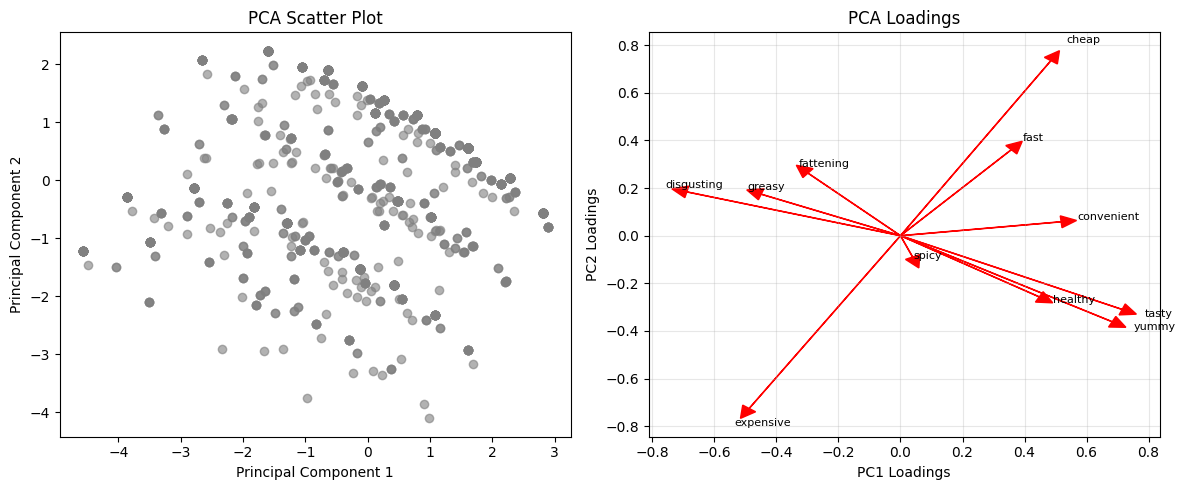

In [13]:

binary_cols = mcdonalds.columns[:11]
MD_x = mcdonalds[binary_cols].copy()
MD_x = (MD_x == 'Yes').astype(int)

print("\nMean values of binary variables:")
print(MD_x.mean().round(2))

print("\n=== PRINCIPAL COMPONENT ANALYSIS ===")
scaler = StandardScaler()
MD_x_scaled = scaler.fit_transform(MD_x)
pca = PCA()
pca_result = pca.fit_transform(MD_x_scaled)

print("\nPCA Summary:")
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

pca_summary = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(explained_var_ratio))],
    'Standard deviation': np.sqrt(pca.explained_variance_),
    'Proportion of Variance': explained_var_ratio,
    'Cumulative Proportion': cumulative_var_ratio
})
print(pca_summary.round(4))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], color='grey', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')

plt.subplot(1, 2, 2)
loadings = pca.components_[:2].T * np.sqrt(pca.explained_variance_[:2])
for i, var in enumerate(binary_cols):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1],
              head_width=0.05, head_length=0.05, fc='red', ec='red')
    plt.text(loadings[i, 0]*1.1, loadings[i, 1]*1.1, var, fontsize=8)
plt.xlabel('PC1 Loadings')
plt.ylabel('PC2 Loadings')
plt.title('PCA Loadings')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

K-Means  Clustering


=== K-MEANS CLUSTERING ===


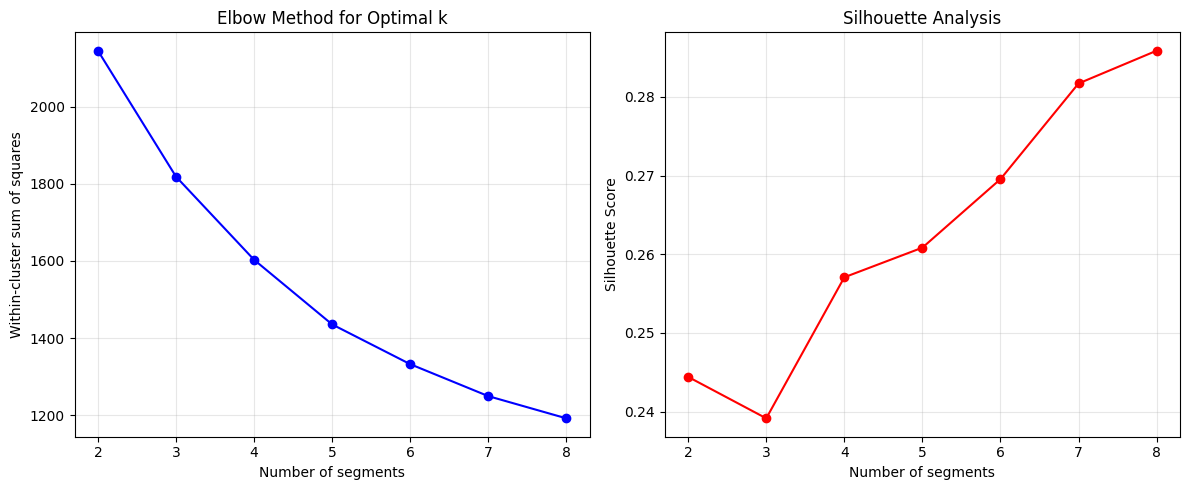

In [14]:
print("\n=== K-MEANS CLUSTERING ===")
k_range = range(2, 9)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=1234, n_init=10)
    kmeans.fit(MD_x)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(MD_x, kmeans.labels_))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of segments')
plt.ylabel('Within-cluster sum of squares')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of segments')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

K-Means Clustering with 4 clusters


=== K-MEANS WITH 4 CLUSTERS ===


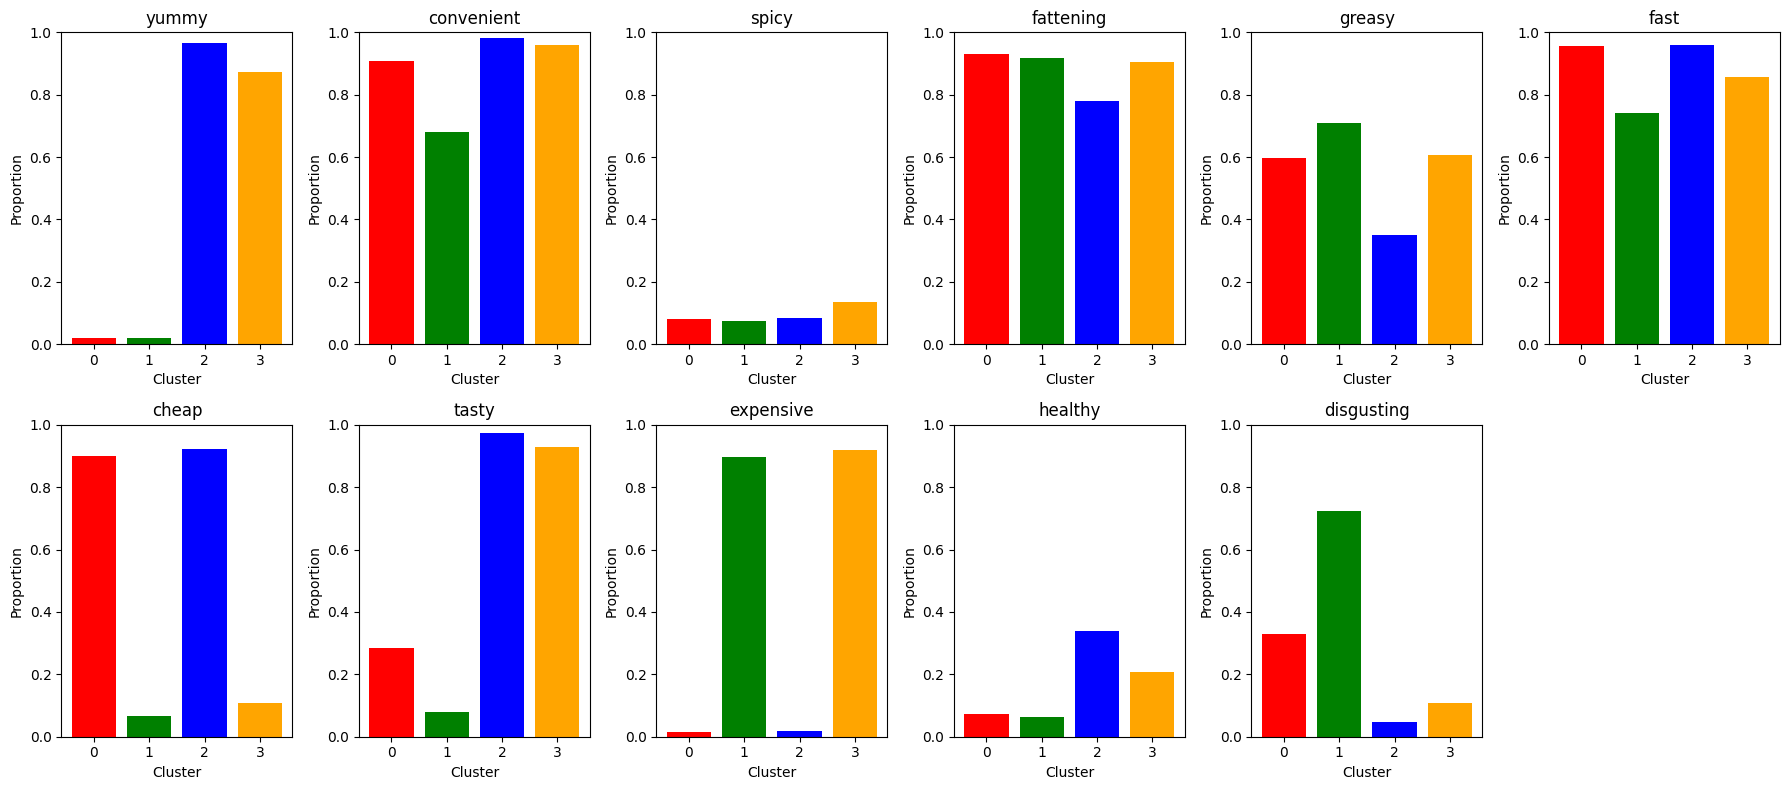


=== CLUSTER STABILITY ANALYSIS ===


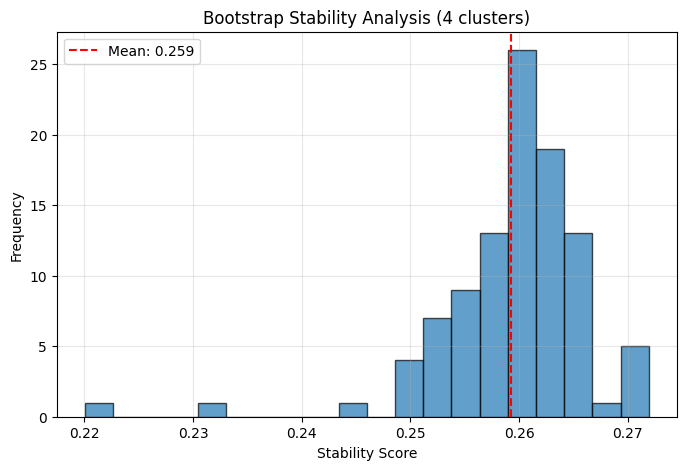

In [15]:
print("\n=== K-MEANS WITH 4 CLUSTERS ===")
kmeans_4 = KMeans(n_clusters=4, random_state=1234, n_init=10)
k4_labels = kmeans_4.fit_predict(MD_x)

fig, axes = plt.subplots(2, 6, figsize=(18, 8))
axes = axes.ravel()

for i, col in enumerate(binary_cols):
    cluster_means = [MD_x[k4_labels == j][col].mean() for j in range(4)]
    axes[i].bar(range(4), cluster_means, color=['red', 'green', 'blue', 'orange'])
    axes[i].set_title(col)
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('Proportion')
    axes[i].set_ylim(0, 1)

axes[-1].remove()
plt.tight_layout()
plt.show()

print("\n=== CLUSTER STABILITY ANALYSIS ===")
n_bootstrap = 100
stability_scores = []

for _ in range(n_bootstrap):
    bootstrap_idx = np.random.choice(len(MD_x), len(MD_x), replace=True)
    bootstrap_data = MD_x.iloc[bootstrap_idx]

    bootstrap_kmeans = KMeans(n_clusters=4, random_state=None, n_init=10)
    bootstrap_labels = bootstrap_kmeans.fit_predict(bootstrap_data)

    stability_scores.append(silhouette_score(bootstrap_data, bootstrap_labels))

plt.figure(figsize=(8, 5))
plt.hist(stability_scores, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Stability Score')
plt.ylabel('Frequency')
plt.title('Bootstrap Stability Analysis (4 clusters)')
plt.axvline(np.mean(stability_scores), color='red', linestyle='--',
            label=f'Mean: {np.mean(stability_scores):.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

DEMOGRAPHIC ANALYSIS

In [16]:
print("\n=== DEMOGRAPHIC ANALYSIS ===")

like_mapping = {
    'I hate it!-5': -5, 'I hate it!-4': -4, 'I hate it!-3': -3,
    'I like it!+3': 3, 'I like it!+4': 4, 'I love it!+5': 5
}
mcdonalds['Like_n'] = mcdonalds['Like'].map(like_mapping)

visit_mapping = {'Never': 1, 'Rarely': 2, 'Sometimes': 3, 'Often': 4}
mcdonalds['VisitFrequency_n'] = mcdonalds['VisitFrequency'].map(visit_mapping)

mcdonalds['Cluster'] = k4_labels

print("Cluster characteristics:")
cluster_summary = mcdonalds.groupby('Cluster').agg({
    'Like_n': 'mean',
    'Age': 'mean',
    'VisitFrequency_n': 'mean'
}).round(2)

gender_prop = mcdonalds.groupby('Cluster')['Gender'].apply(
    lambda x: (x == 'Female').mean()
).round(2)
cluster_summary['Female_prop'] = gender_prop

print(cluster_summary)


=== DEMOGRAPHIC ANALYSIS ===
Cluster characteristics:
         Like_n    Age  VisitFrequency_n  Female_prop
Cluster                                              
0         -5.00  49.14               1.0         0.59
1         -5.00  48.07               1.0         0.42
2          4.80  42.87               1.0         0.61
3          3.98  39.68               1.0         0.47


Variable Clustering


=== VARIABLE CLUSTERING ===


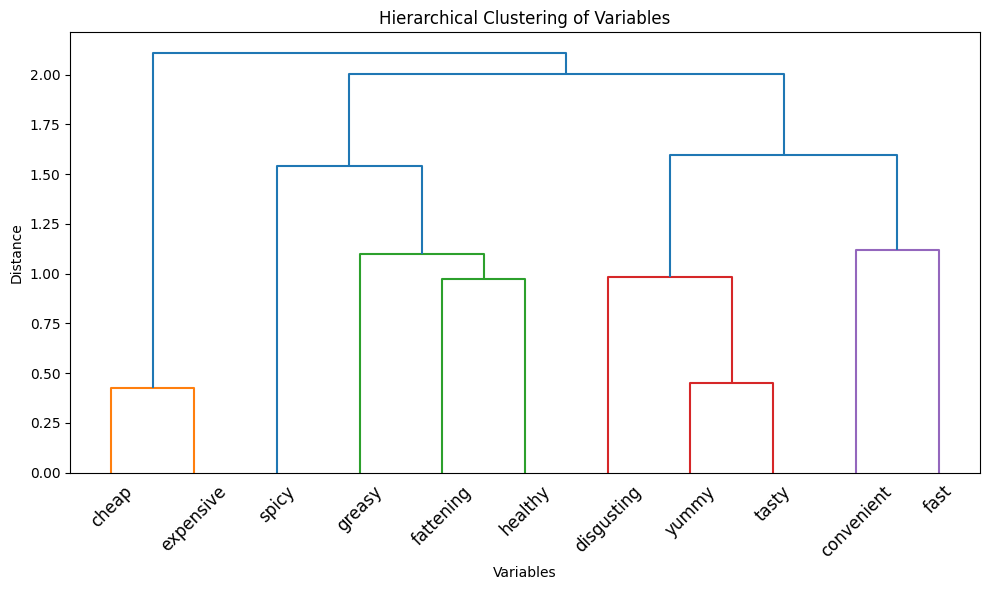

In [17]:
print("\n=== VARIABLE CLUSTERING ===")
corr_matrix = MD_x.corr()
distance_matrix = 1 - np.abs(corr_matrix)

linkage_matrix = linkage(pdist(distance_matrix), method='ward')

plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=binary_cols, orientation='top')
plt.title('Hierarchical Clustering of Variables')
plt.xlabel('Variables')
plt.ylabel('Distance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


=== CLUSTER VISUALIZATION IN PCA SPACE ===


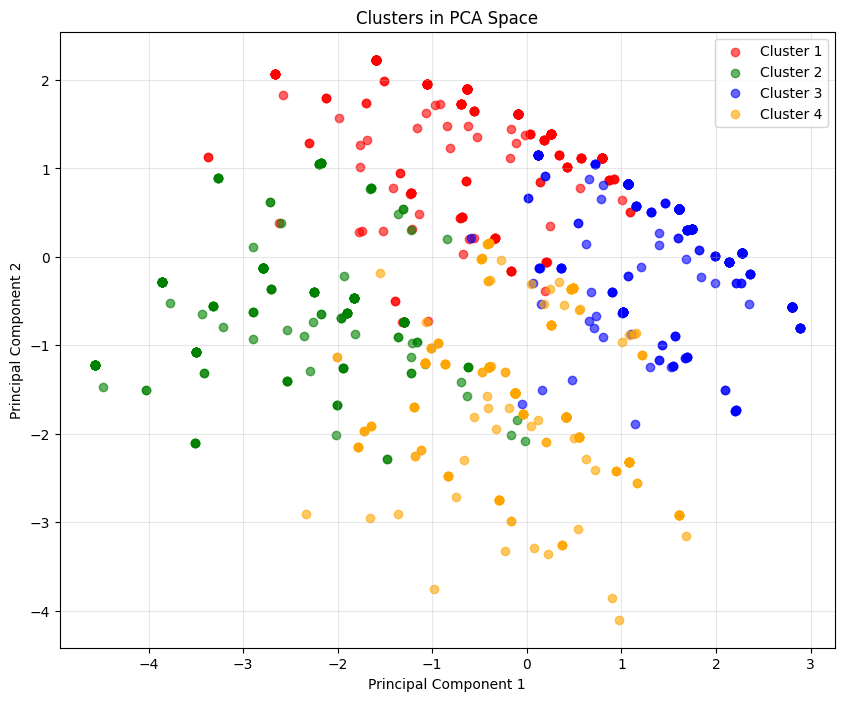


=== CONTINGENCY ANALYSIS ===
Cluster vs Like contingency table:
Like     +1  +2   +3   +4  -1  -2  -3  -4   0  I hate it!-5  I love it!+5
Cluster                                                                  
0        46  44   17    3  30  29  35  38  66            56             0
1        14   6    8    0  12  18  30  27  36            89             0
2        51  79  138  110  10   6   1   3  34             2            99
3        41  58   66   47   6   6   7   3  33             5            44

Chi-square test: χ² = 828.36, p-value = 0.0000

Cluster vs Gender contingency table:
Gender   Female  Male
Cluster              
0           213   151
1           101   139
2           324   209
3           150   166

=== DECISION TREE ANALYSIS ===


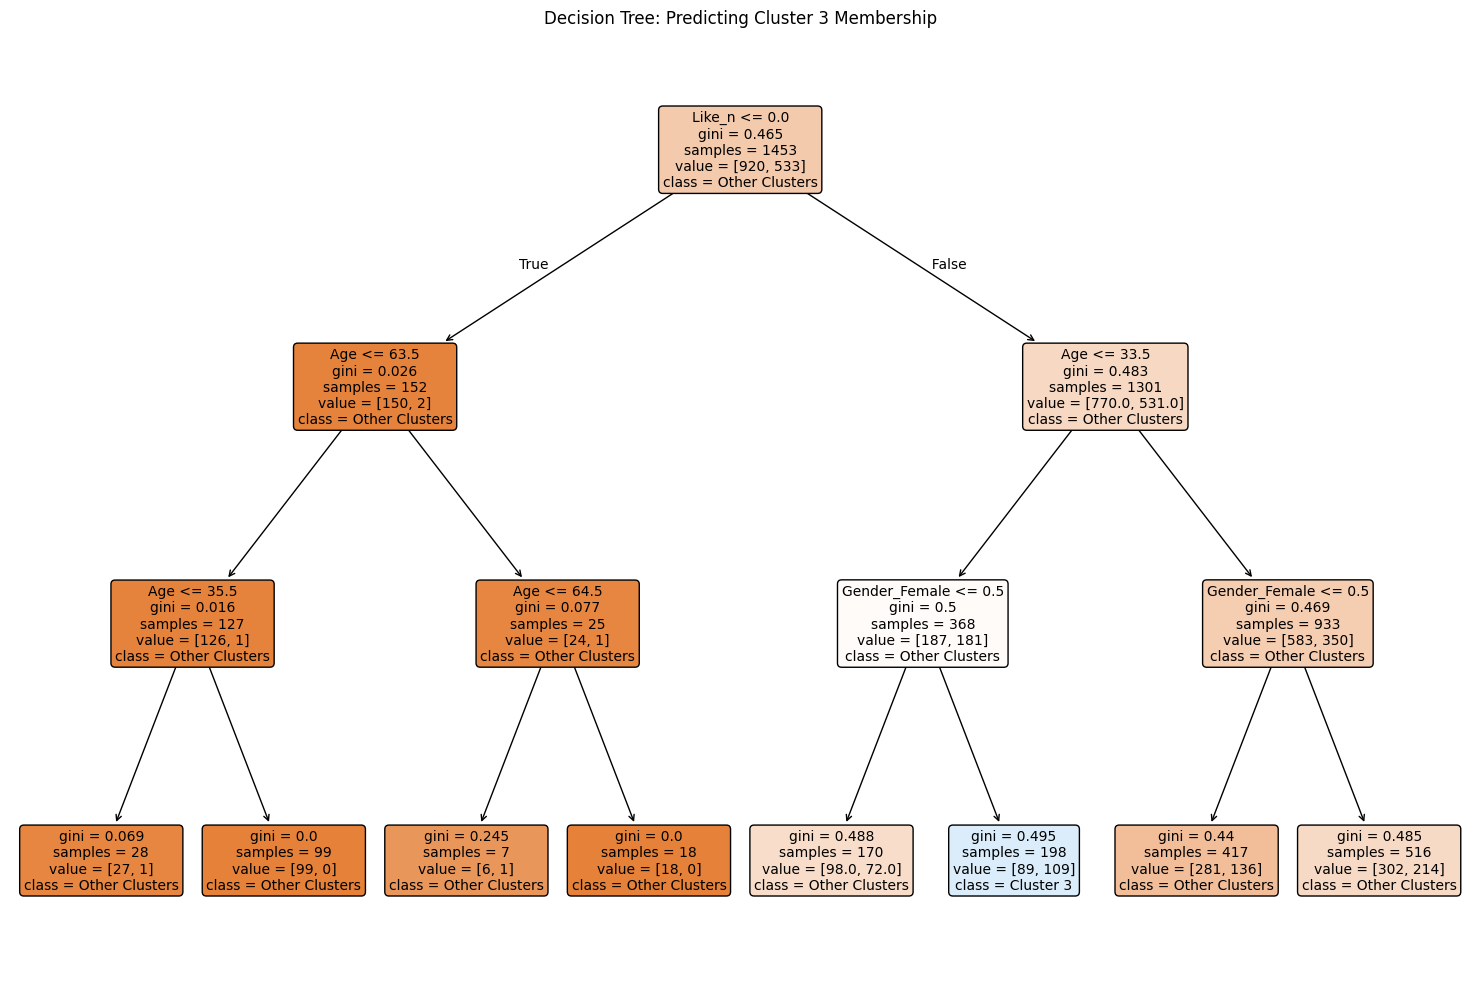


=== BUBBLE PLOT ANALYSIS ===


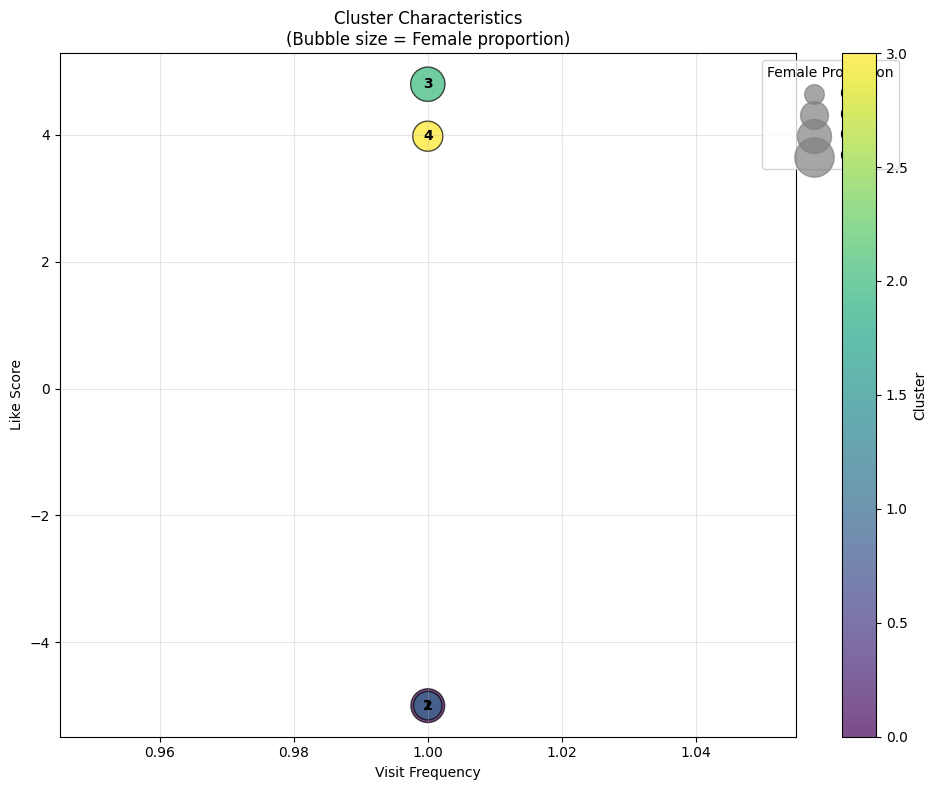

In [18]:
print("\n=== CLUSTER VISUALIZATION IN PCA SPACE ===")
plt.figure(figsize=(10, 8))
colors = ['red', 'green', 'blue', 'orange']
for i in range(4):
    cluster_points = pca_result[k4_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                c=colors[i], label=f'Cluster {i+1}', alpha=0.6)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters in PCA Space')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n=== CONTINGENCY ANALYSIS ===")

like_cluster_crosstab = pd.crosstab(mcdonalds['Cluster'], mcdonalds['Like'])
print("Cluster vs Like contingency table:")
print(like_cluster_crosstab)

chi2, p_value, dof, expected = chi2_contingency(like_cluster_crosstab)
print(f"\nChi-square test: χ² = {chi2:.2f}, p-value = {p_value:.4f}")

gender_cluster_crosstab = pd.crosstab(mcdonalds['Cluster'], mcdonalds['Gender'])
print("\nCluster vs Gender contingency table:")
print(gender_cluster_crosstab)

print("\n=== DECISION TREE ANALYSIS ===")
target = (k4_labels == 2).astype(int)

features = mcdonalds[['Like_n', 'Age', 'VisitFrequency_n']].copy()
features['Gender_Female'] = (mcdonalds['Gender'] == 'Female').astype(int)

tree_model = DecisionTreeClassifier(random_state=1234, max_depth=3)
tree_model.fit(features, target)

plt.figure(figsize=(15, 10))
plot_tree(tree_model, feature_names=features.columns,
          class_names=['Other Clusters', 'Cluster 3'],
          filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree: Predicting Cluster 3 Membership')
plt.tight_layout()
plt.show()

print("\n=== BUBBLE PLOT ANALYSIS ===")
visit_means = cluster_summary['VisitFrequency_n']
like_means = cluster_summary['Like_n']
female_props = cluster_summary['Female_prop']

plt.figure(figsize=(10, 8))
scatter = plt.scatter(visit_means, like_means, s=female_props*1000,
                     c=range(4), cmap='viridis', alpha=0.7, edgecolors='black')

for i, (x, y) in enumerate(zip(visit_means, like_means)):
    plt.text(x, y, str(i+1), ha='center', va='center', fontweight='bold')

plt.xlabel('Visit Frequency')
plt.ylabel('Like Score')
plt.title('Cluster Characteristics\n(Bubble size = Female proportion)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)

bubble_sizes = [0.2, 0.4, 0.6, 0.8]
legend_bubbles = []
for size in bubble_sizes:
    legend_bubbles.append(plt.scatter([], [], s=size*1000, c='gray', alpha=0.7))
plt.legend(legend_bubbles, [f'{size:.1f}' for size in bubble_sizes],
           title='Female Proportion', loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()
